In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from DataTransformation import LowPassFilter, PrincipalComponentAnalysis
from TemporalAbstraction import NumericalAbstraction
from FrequencyAbstraction import FourierTransformation
from sklearn.cluster import KMeans

# Set global plot style and parameters
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = [20, 10]  # Set figure size
plt.rcParams["figure.dpi"] = 100  # Set figure resolution


In [31]:

# --------------------------------------------------------------
# Load data
# --------------------------------------------------------------
df = pd.read_pickle("../../../data/interim/02_outliers_removed_chauvenet.pkl")

df


,gyr_x,acc_x,acc_y,acc_z,gyr_y,gyr_z,label,category,participant,set,set'
epoch (ms),,,,,,,,,,,
2019-01-11 15:08:05.200,-1.8904,0.013500,0.977000,-0.071000,2.4392,0.9388,bench,heavy,B,64.0,64
2019-01-11 15:08:05.400,-1.6826,-0.001500,0.970500,-0.079500,-0.8904,2.1708,bench,heavy,B,64.0,64
2019-01-11 15:08:05.600,2.5608,0.001333,0.971667,-0.064333,-0.2560,-1.4146,bench,heavy,B,64.0,64
2019-01-11 15:08:05.800,8.0610,-0.024000,0.957000,-0.073500,-4.5244,-2.0730,bench,heavy,B,64.0,64
2019-01-11 15:08:06.000,2.4390,-0.028000,0.957667,-0.115000,-1.5486,-3.6098,bench,heavy,B,64.0,64
...,...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:33:27.000,1.4146,-0.048000,-1.041500,-0.076500,-5.6218,0.2926,row,medium,E,71.0,71
2019-01-20 17:33:27.200,-2.7684,-0.037000,-1.030333,-0.053333,-0.5854,2.2440,row,medium,E,71.0,71
2019-01-20 17:33:27.400,2.8416,-0.060000,-1.031000,-0.082000,-5.1342,-0.1220,row,medium,E,71.0,71


In [32]:

predictor_columns = df.columns[:6].tolist()

df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9009 entries, 2019-01-11 15:08:05.200000 to 2019-01-20 17:33:27.800000
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   gyr_x        8984 non-null   float64
 1   acc_x        9005 non-null   float64
 2   acc_y        8998 non-null   float64
 3   acc_z        8999 non-null   float64
 4   gyr_y        8938 non-null   float64
 5   gyr_z        8945 non-null   float64
 6   label        9009 non-null   object 
 7   category     9009 non-null   object 
 8   participant  9009 non-null   object 
 9   set          9009 non-null   float64
 10  set'         9009 non-null   int64  
dtypes: float64(7), int64(1), object(3)
memory usage: 844.6+ KB


In [33]:
df.isna().sum()

gyr_x          25
acc_x           4
acc_y          11
acc_z          10
gyr_y          71
gyr_z          64
label           0
category        0
participant     0
set             0
set'            0
dtype: int64

In [34]:

# --------------------------------------------------------------
# Dealing with missing values (imputation)
# --------------------------------------------------------------

for col in predictor_columns:
    df[col] = df[col].interpolate()

df.isna().sum()


gyr_x          0
acc_x          0
acc_y          0
acc_z          0
gyr_y          0
gyr_z          0
label          0
category       0
participant    0
set            0
set'           0
dtype: int64

20.4

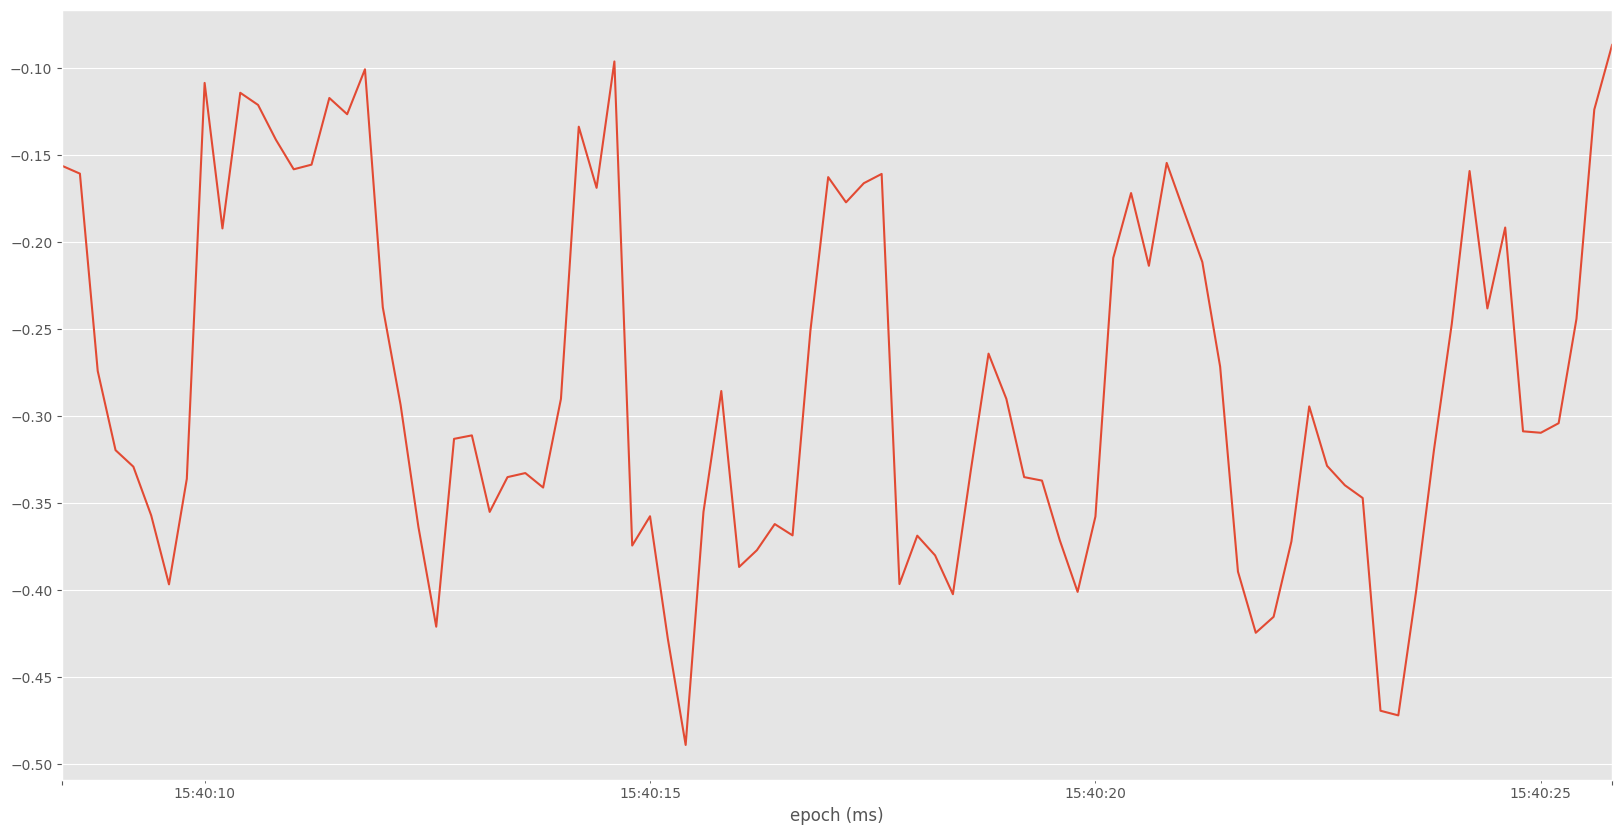

In [35]:

# --------------------------------------------------------------
# Calculating set duration
# --------------------------------------------------------------

df.query("set == 10")["acc_x"].plot()

duration = df.query("set == 1").index[-1] - df.query("set == 1").index[0]
duration.total_seconds()



In [36]:

for set in df["set"].unique():
    duration = df.query("set == @set").index[-1] - df.query("set == @set").index[0]

    df.loc[(df["set"] == set), "duration"] = duration.seconds

duration_df = df.groupby(["category"])["duration"].mean()

duration_df[0] / 5 , duration_df[1] / 10


(2.9487001733102254, 2.4942528735632186)

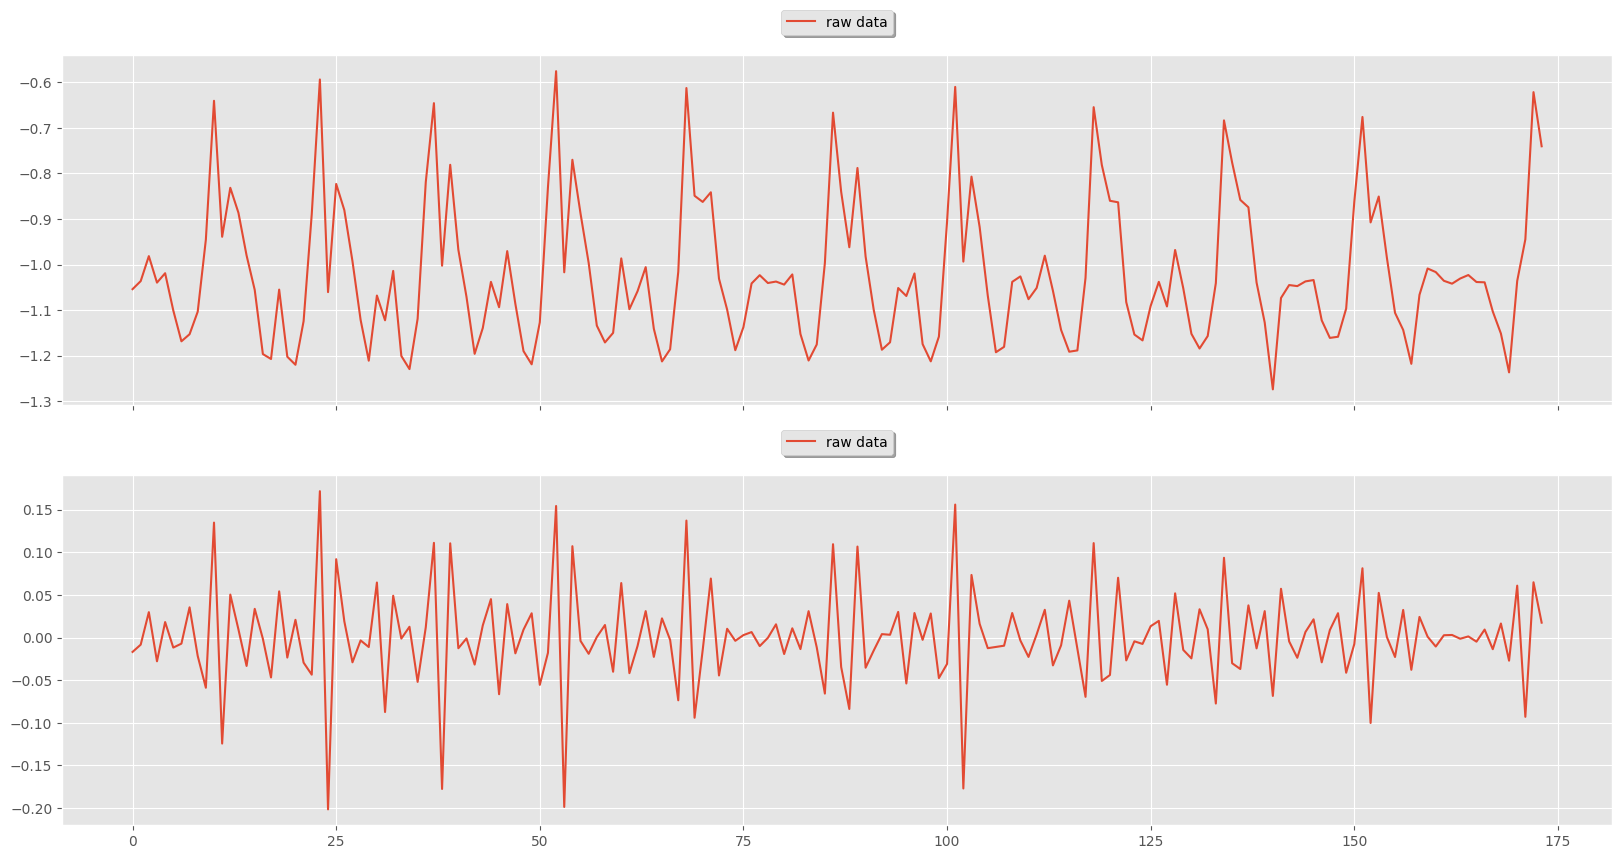

In [37]:

# --------------------------------------------------------------
# Butterworth lowpass filter
# --------------------------------------------------------------

df_lowpass = df.copy()
Lowpass = LowPassFilter()

fs = 1000 / 200
cutoff = 1.3
df_lowpass = Lowpass.low_pass_filter(df_lowpass, "acc_y", fs, cutoff, order=5)

subset = df_lowpass.query("set == 45")

fig, ax = plt.subplots(nrows=2, sharex=True)
ax[0].plot(subset["acc_y"].reset_index(drop=True), label="raw data")
ax[1].plot(subset["acc_y_lowpass"].reset_index(drop=True), label="raw data")
ax[0].legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), fancybox=True, shadow=True)
ax[1].legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), fancybox=True, shadow=True)

for col in predictor_columns:
    df_lowpass = Lowpass.low_pass_filter(df_lowpass, col, fs, cutoff, order=5)
    df_lowpass[col] = df_lowpass[col + "_lowpass"]
    del df_lowpass[col + "_lowpass"]


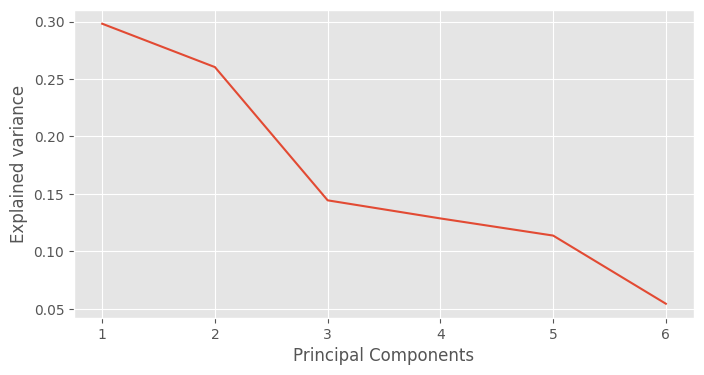

<AxesSubplot: xlabel='epoch (ms)'>

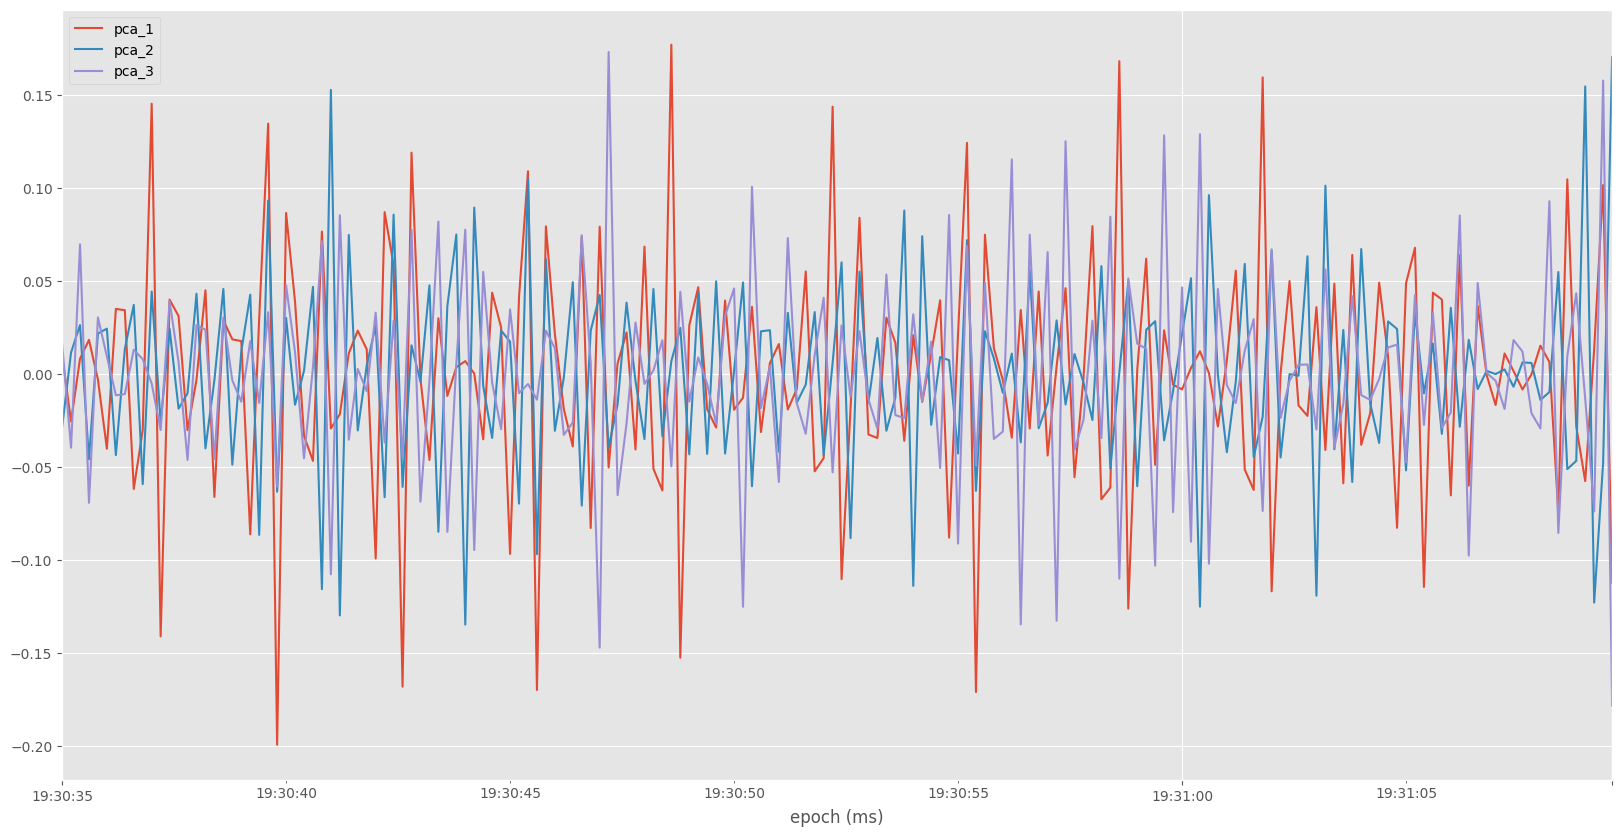

In [38]:

# --------------------------------------------------------------
# Principal component analysis PCA
# --------------------------------------------------------------

df_pca = df_lowpass.copy()
PCA = PrincipalComponentAnalysis()

pc_values = PCA.determine_pc_explained_variance(df_pca, predictor_columns)

plt.figure(figsize=(8, 4))
plt.plot(range(1, len(predictor_columns) + 1), pc_values)
plt.xlabel("Principal Components")
plt.ylabel("Explained variance")
plt.show()

df_pca = PCA.apply_pca(df_pca, predictor_columns, 3)

subset = df_pca.query("set == 45")
subset[["pca_1", "pca_2", "pca_3"]].plot()


array([<AxesSubplot: xlabel='epoch (ms)'>,
       <AxesSubplot: xlabel='epoch (ms)'>], dtype=object)

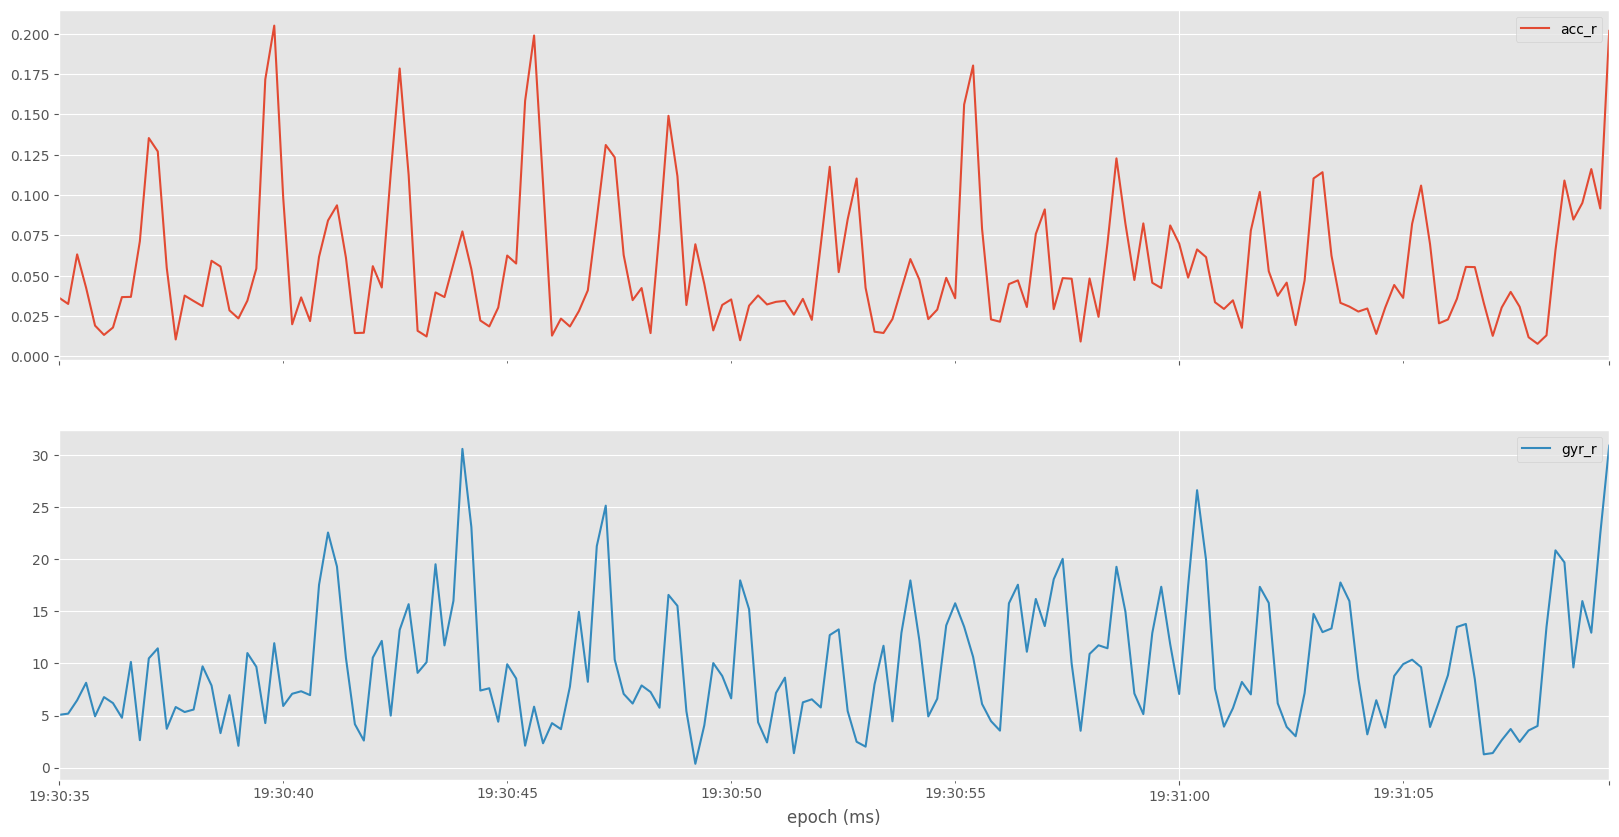

In [39]:

# --------------------------------------------------------------
# Sum of squares attributes
# --------------------------------------------------------------

df_squared = df_pca.copy()
acc_r = df_squared["acc_x"] ** 2 + df_squared["acc_y"] ** 2 + df_squared["acc_z"] ** 2
gyr_r = df_squared["gyr_x"] ** 2 + df_squared["gyr_y"] ** 2 + df_squared["gyr_z"] ** 2

df_squared["acc_r"] = np.sqrt(acc_r)
df_squared["gyr_r"] = np.sqrt(gyr_r)

subset = df_squared.query("set == 45")
subset[["acc_r", "gyr_r"]].plot(subplots=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9009 entries, 2019-01-11 15:08:05.200000 to 2019-01-20 17:33:27.800000
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   gyr_x                 9009 non-null   float64
 1   acc_x                 9009 non-null   float64
 2   acc_y                 9009 non-null   float64
 3   acc_z                 9009 non-null   float64
 4   gyr_y                 9009 non-null   float64
 5   gyr_z                 9009 non-null   float64
 6   label                 9009 non-null   object 
 7   category              9009 non-null   object 
 8   participant           9009 non-null   object 
 9   set                   9009 non-null   float64
 10  set'                  9009 non-null   int64  
 11  duration              9009 non-null   float64
 12  pca_1                 9009 non-null   float64
 13  pca_2                 9009 non-null   float64
 14  pca_3                 

array([<AxesSubplot: xlabel='epoch (ms)'>,
       <AxesSubplot: xlabel='epoch (ms)'>,
       <AxesSubplot: xlabel='epoch (ms)'>], dtype=object)

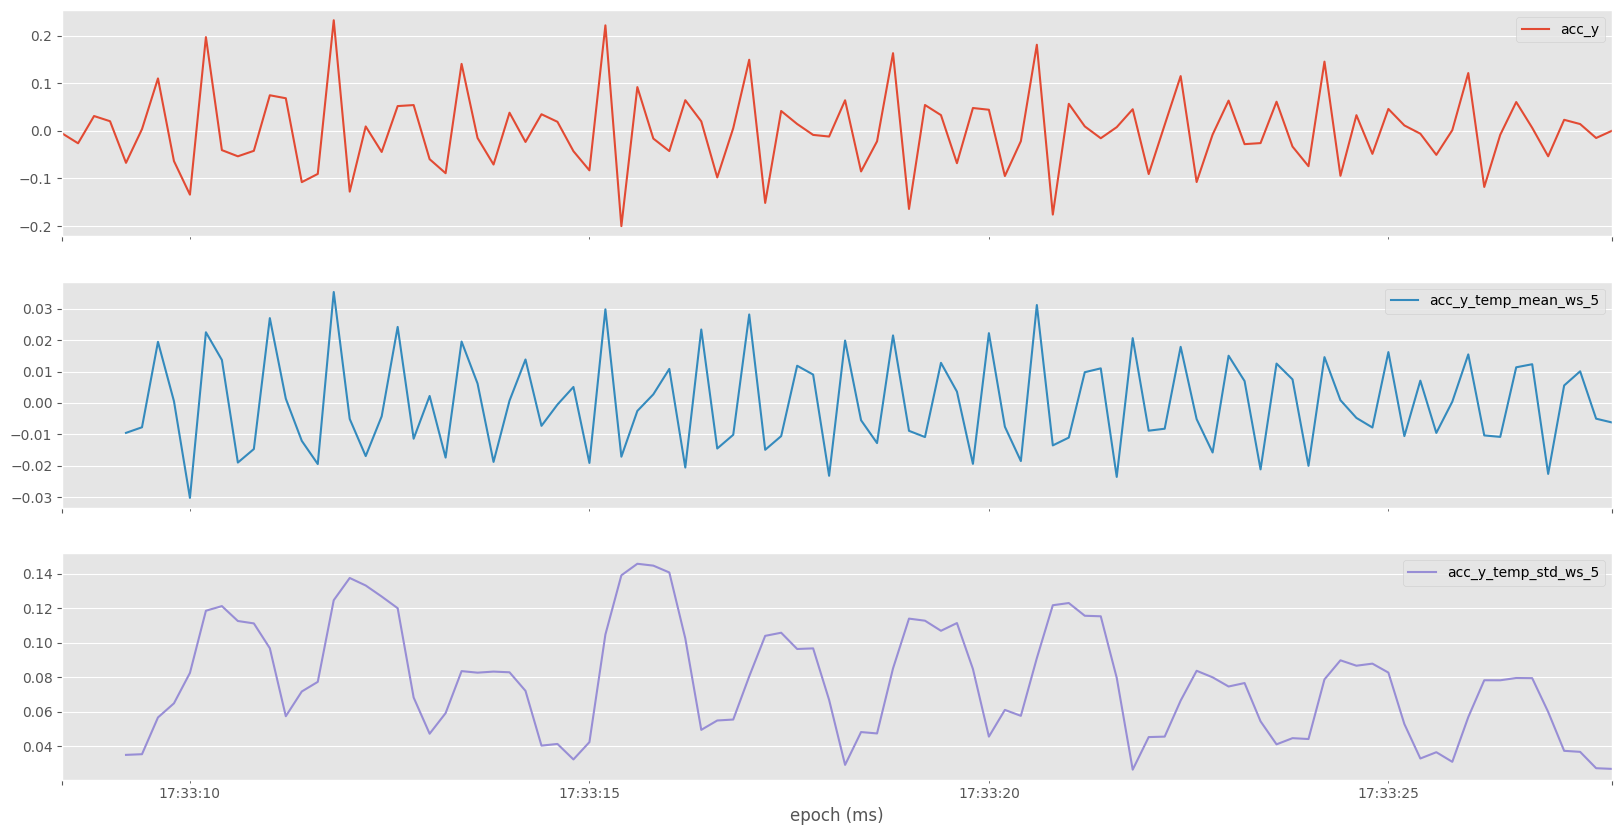

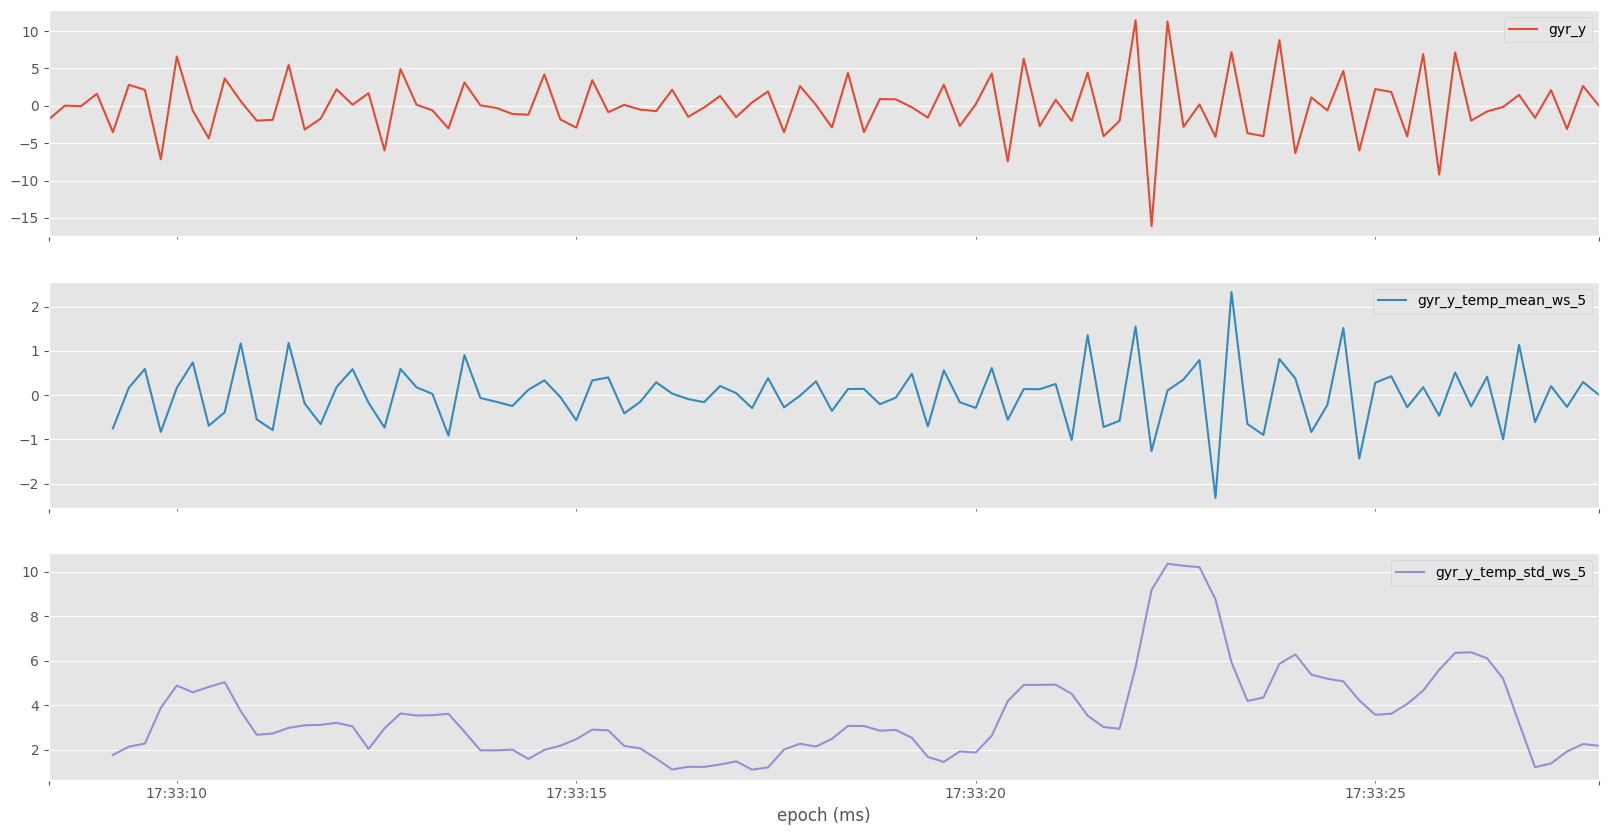

In [40]:

# --------------------------------------------------------------
# Temporal abstraction
# --------------------------------------------------------------

df_temporal = df_squared.copy()
NumAbs = NumericalAbstraction()

predictor_columns = predictor_columns + ["acc_r", "gyr_r"]

ws = int(1000 / 200)

for col in predictor_columns:
    df_temporal = NumAbs.abstract_numerical(df_temporal, [col], ws, "mean")
    df_temporal = NumAbs.abstract_numerical(df_temporal, [col], ws, "std")


df_temporal_list = []
for s in df_temporal["set"].unique():
    subset = df_temporal[df_temporal["set"] == s].copy()
    for col in predictor_columns:
        subset = NumAbs.abstract_numerical(subset, [col], ws, "mean")
        subset = NumAbs.abstract_numerical(subset, [col], ws, "std")

    df_temporal_list.append(subset)

df_temporal = pd.concat(df_temporal_list)
df_temporal.info()


subset[["acc_y", "acc_y_temp_mean_ws_5", "acc_y_temp_std_ws_5"]].plot(subplots=True)
subset[["gyr_y", "gyr_y_temp_mean_ws_5", "gyr_y_temp_std_ws_5"]].plot(subplots=True)



array([<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
       <AxesSubplot: >], dtype=object)

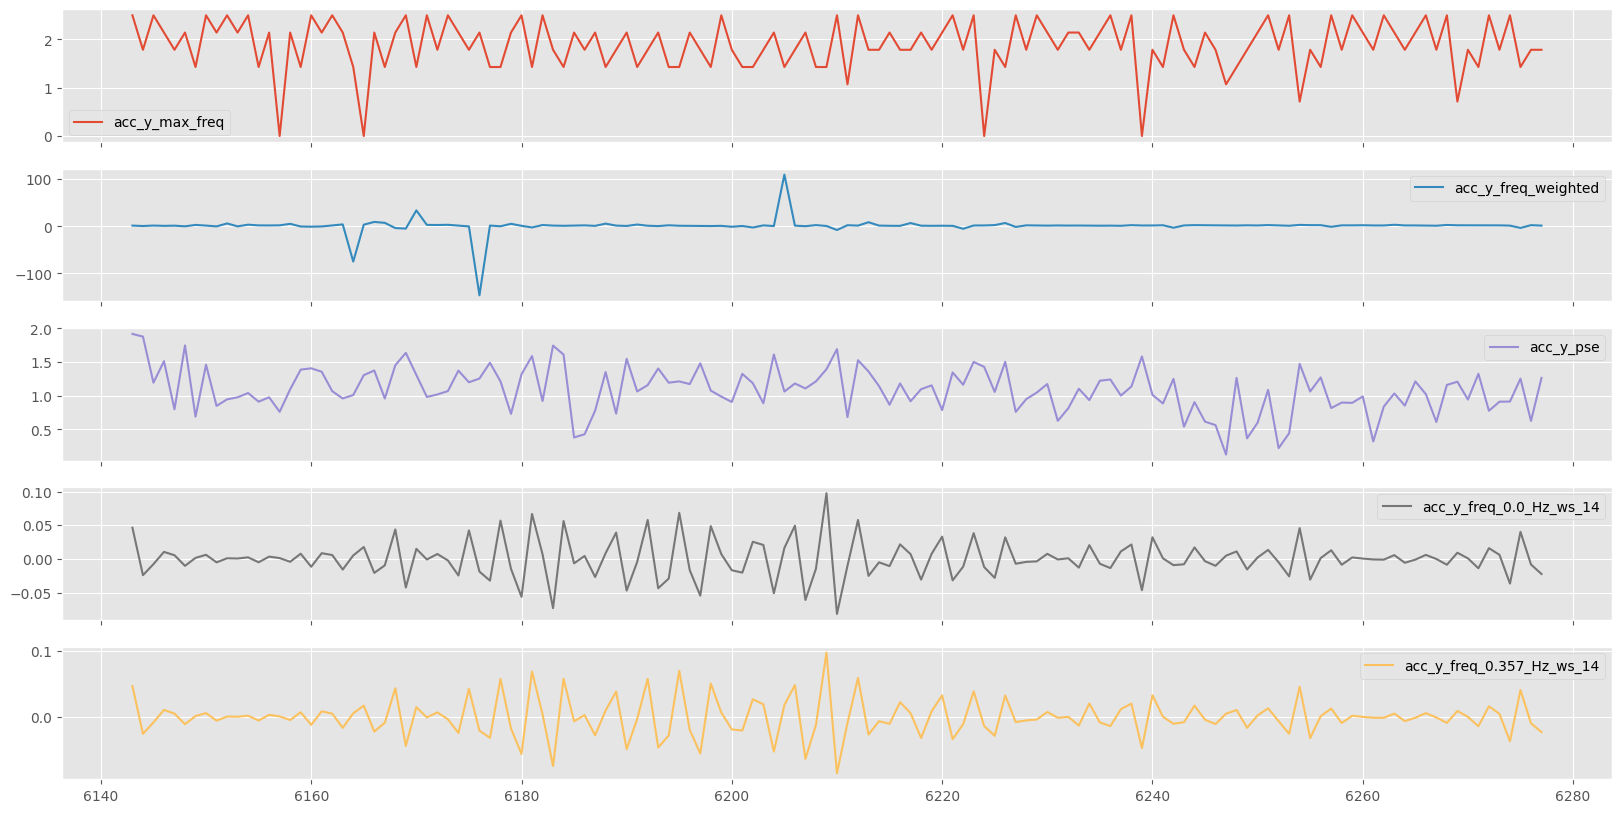

In [41]:

# --------------------------------------------------------------
# Frequency features
# --------------------------------------------------------------

df_freq = df_temporal.copy().reset_index()
FreqAbs = FourierTransformation()

fs = int(1000 / 200)
ws = int(2800 / 200)

df_freq = FreqAbs.abstract_frequency(df_freq, ["acc_y"], ws, fs)
df_freq.columns
subset = df_freq.query("set == 14")
subset[
    [
        "acc_y_max_freq",
        "acc_y_freq_weighted",
        "acc_y_pse",
        "acc_y_freq_0.0_Hz_ws_14",
        "acc_y_freq_0.357_Hz_ws_14",
    ]
].plot(subplots=True)

In [42]:

df_freq_list = []
for s in df_freq["set"].unique():
    subset = df_freq[df_freq["set"] == s].reset_index(drop=True).copy()
    subset = FreqAbs.abstract_frequency(subset, predictor_columns, ws, fs)
    df_freq_list.append(subset)

df_freq = pd.concat(df_freq_list).set_index("epoch (ms)", drop=True)
df_freq.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9009 entries, 2019-01-11 15:08:05.200000 to 2019-01-20 17:33:27.800000
Columns: 121 entries, gyr_x to gyr_r_freq_2.5_Hz_ws_14
dtypes: float64(117), int64(1), object(3)
memory usage: 8.4+ MB


In [43]:

# --------------------------------------------------------------
# Dealing with overlapping windows
# --------------------------------------------------------------

df_freq = df_freq.dropna()
df_freq.isna().sum()
df_freq = df_freq.iloc[::2]

Clustering for 2 cluster
Clustering for 3 cluster
Clustering for 4 cluster
Clustering for 5 cluster
Clustering for 6 cluster
Clustering for 7 cluster
Clustering for 8 cluster
Clustering for 9 cluster


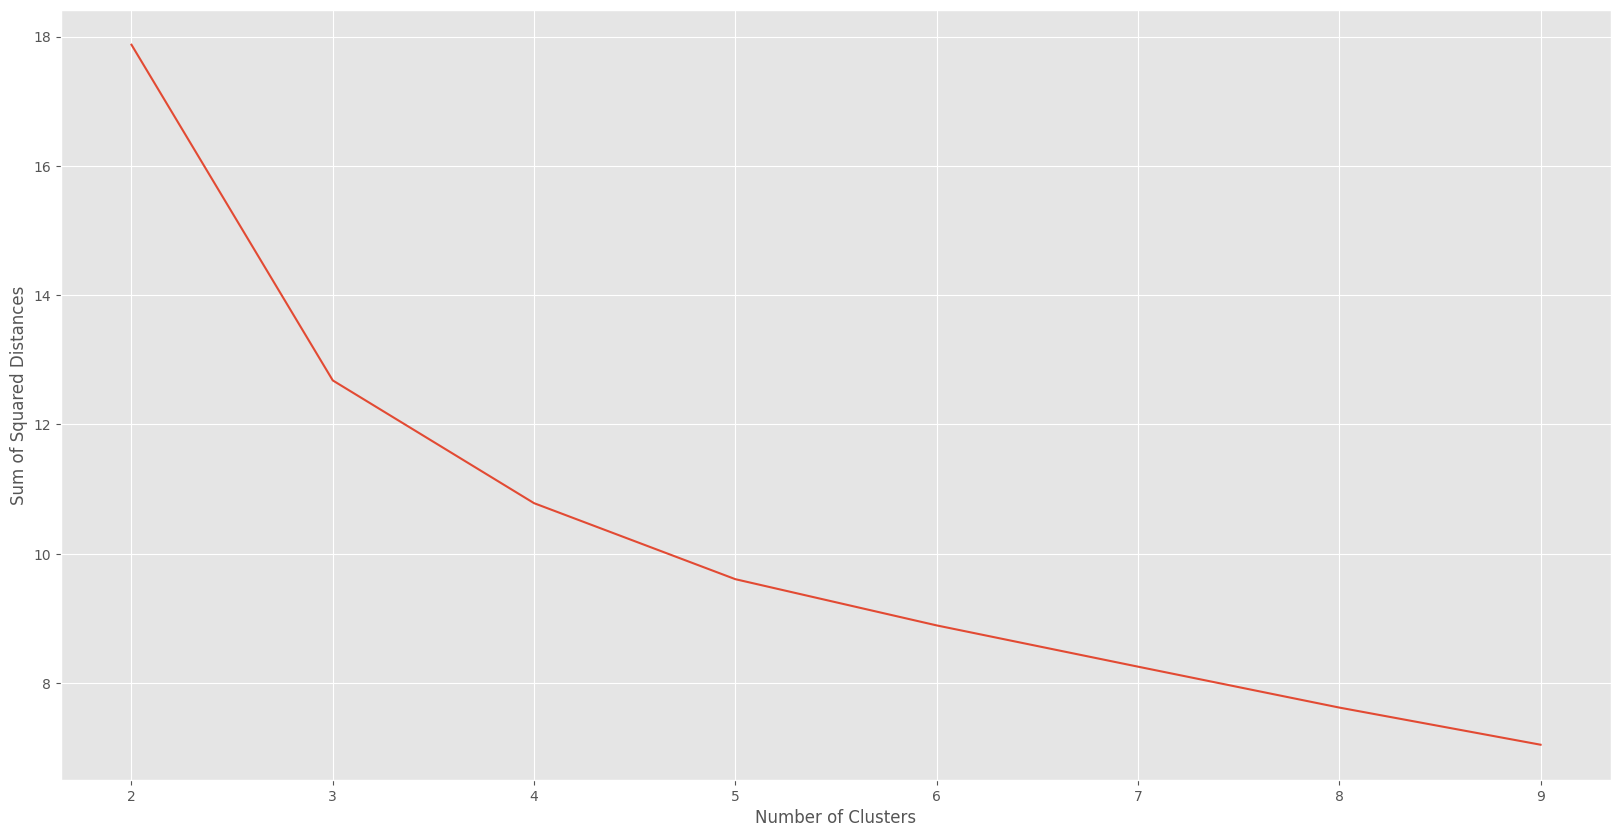

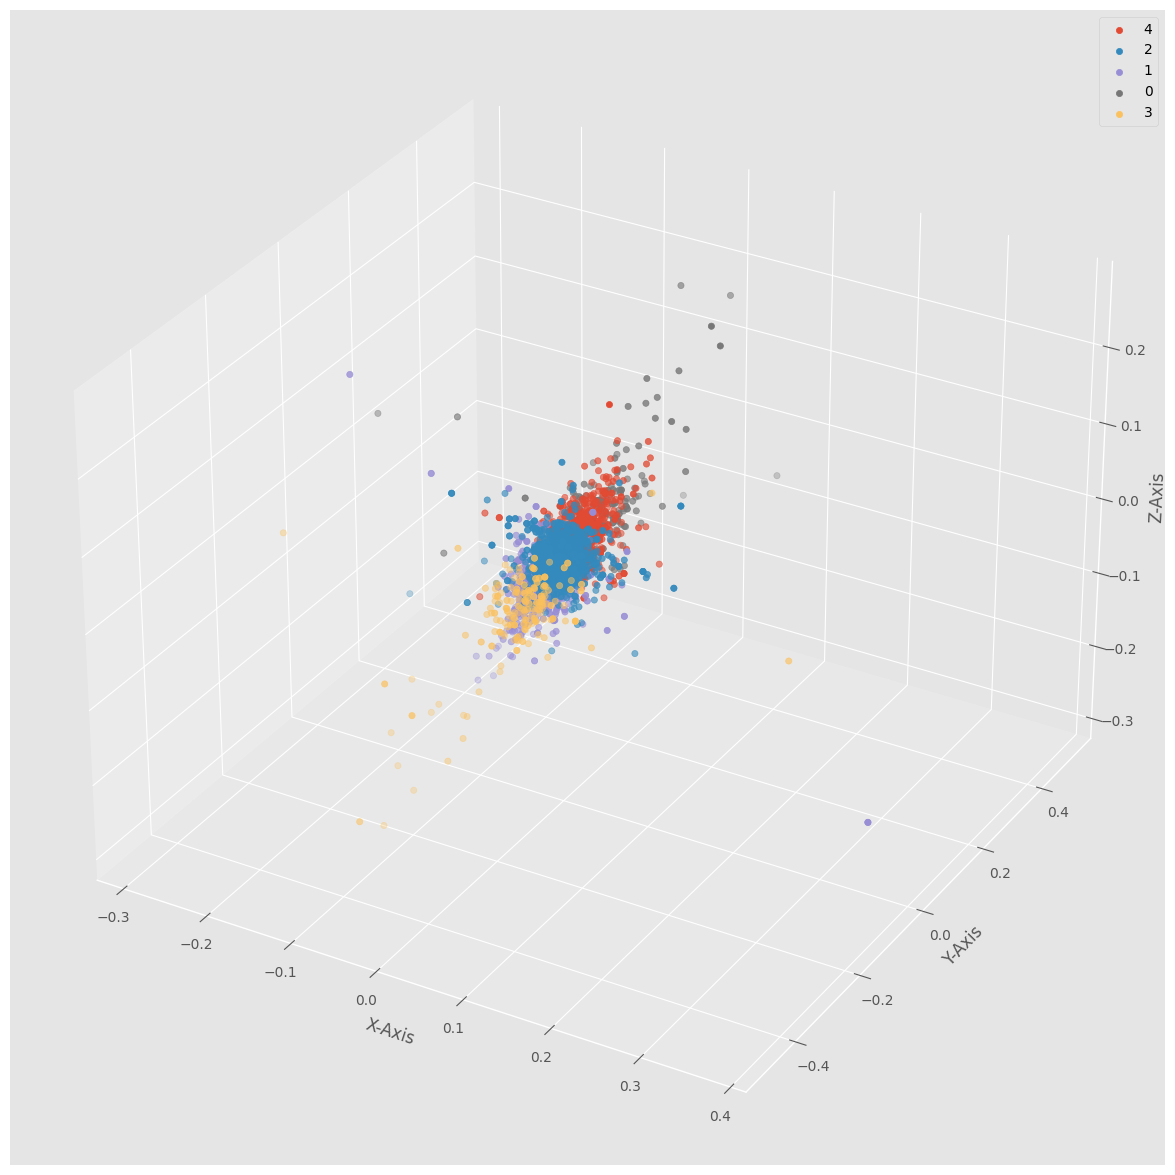

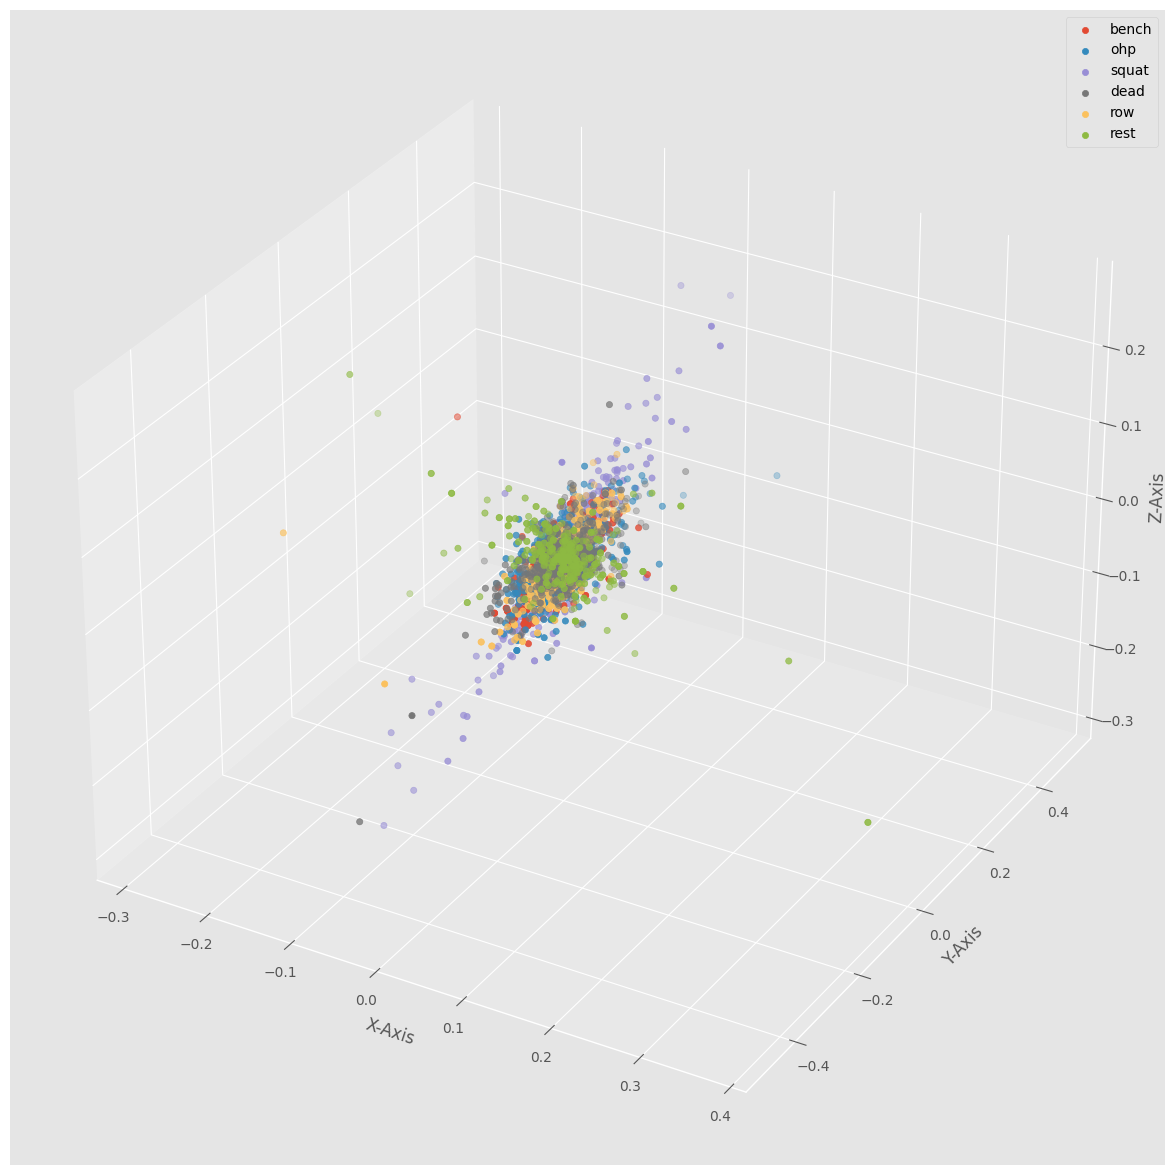

gyr_x                        0
acc_x                        0
acc_y                        0
acc_z                        0
gyr_y                        0
                            ..
gyr_r_freq_1.429_Hz_ws_14    0
gyr_r_freq_1.786_Hz_ws_14    0
gyr_r_freq_2.143_Hz_ws_14    0
gyr_r_freq_2.5_Hz_ws_14      0
cluster                      0
Length: 122, dtype: int64

In [44]:

# --------------------------------------------------------------
# Clustering
# --------------------------------------------------------------

df_cluster = df_freq.copy()
cluster_columns = ["acc_x", "acc_y", "acc_z"]
k_values = range(2, 10)
inertias = []

for k in k_values:
    print(f"Clustering for {k} cluster")
    subset = df_cluster[cluster_columns]
    kmeans = KMeans(n_clusters=k, n_init=20, random_state=0)
    cluster_labels = kmeans.fit_predict(subset)
    inertias.append(kmeans.inertia_)

plt.figure()
plt.plot(k_values, inertias)
plt.xlabel("Number of Clusters")
plt.ylabel("Sum of Squared Distances")
plt.show()

kmeans = KMeans(n_clusters=5, n_init=20, random_state=0)
subset = df_cluster[cluster_columns]
df_cluster["cluster"] = kmeans.fit_predict(subset)


fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(projection="3d")
for c in df_cluster["cluster"].unique():
    subset = df_cluster[df_cluster["cluster"] == c]
    ax.scatter(subset["acc_x"], subset["acc_y"], subset["acc_z"], label=c)
ax.set_xlabel("X-Axis")
ax.set_ylabel("Y-Axis")
ax.set_zlabel("Z-Axis")
plt.legend()
plt.show()


fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(projection="3d")
for l in df_cluster["label"].unique():
    subset = df_cluster[df_cluster["label"] == l]
    ax.scatter(subset["acc_x"], subset["acc_y"], subset["acc_z"], label=l)
ax.set_xlabel("X-Axis")
ax.set_ylabel("Y-Axis")
ax.set_zlabel("Z-Axis")
plt.legend()
plt.show()

df_cluster.isna().sum()

In [45]:

# --------------------------------------------------------------
# Export dataset
# --------------------------------------------------------------

df_cluster.to_pickle("../../../data/interim/03_data_features.pkl")
